In [52]:
import pandas as pd
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

#PS: Pressure, bar, 100 Hz --> 100 Messungen pro Sekunde
#EPS: Motor power, W, 100 Hz 
#FS: Volume flow, l/min, 10 Hz --> 10 Messungen pro Sekunde
#TS: Temperature, Celsius, 1 Hz --> 1 Messung pro Sekunde
#VS: Vibration, mm/s, 1Hz
#CE: Cooling efficiency (virtual), %, 1 Hz
#CP: Cooling power (virtual), kW, 1 Hz
#SE: Efficency factor, %, 1 Hz


class DataProcessor:
    def __init__(self, input_path, file_names):
        self.input_path = input_path
        self.file_names = file_names
        
    def read_files(self):
        self.data = {}
        print("Reading files...")
        for file in self.file_names:
            with open(self.input_path + file + '.txt', 'r') as f:
                self.data[file] = loadtxt(f)
        return self.data
    
    def print_shape(self):
        print("Files read:")
        for file in self.data:
            print(f"{file}: {self.data[file].shape}")
            
    def create_target_df(self):
        target_columns = ['Cooler_Condition', 'Valve_Condition', 
                        'Internal_Pump_Leakage', 'Hydraulic_Accumulator', 
                        'Stable_Flag']
        self.df_target = pd.DataFrame(self.data['target'], columns=target_columns)
        self.valve_condition = self.df_target['Valve_Condition']
        del self.data['target']
        return self.valve_condition

def process_data():
    input_path = "input_data/"
    file_names = [
        "ce", "cp", "eps1", "se", "vs1", 
        "fs1", "fs2", 
        "ps1", "ps2", "ps3", "ps4", "ps5", "ps6",
        "ts1", "ts2", "ts3", "ts4", "target"
    ]
    
    processor = DataProcessor(input_path, file_names)
    data = processor.read_files()
    processor.print_shape()
    processor.create_target_df()
    df_target = processor.valve_condition
    return data, df_target

data, df_target = process_data()

Reading files...
Files read:
ce: (2205, 60)
cp: (2205, 60)
eps1: (2205, 6000)
se: (2205, 60)
vs1: (2205, 60)
fs1: (2205, 600)
fs2: (2205, 600)
ps1: (2205, 6000)
ps2: (2205, 6000)
ps3: (2205, 6000)
ps4: (2205, 6000)
ps5: (2205, 6000)
ps6: (2205, 6000)
ts1: (2205, 60)
ts2: (2205, 60)
ts3: (2205, 60)
ts4: (2205, 60)
target: (2205, 5)


In [53]:
#einzelne Signale in Means abspeichern
data_means = {}
for key in data:
    data_means[key] = np.mean(data[key], axis=1)

In [55]:
data_means['eps1'].shape

(2205,)

In [45]:
# 1. Funktion: Ausreißer entfernen
def remove_outliers(data, threshold=3):
    """
    Entfernt Ausreißer anhand des Z-Scores.
    data: 2D-Array (Zeilen: Kanäle, Spalten: Zeitpunkte)
    threshold: Schwellenwert für Z-Score
    """
    z_scores = (data - np.mean(data, axis=0, keepdims=True)) / np.std(data, axis=0, keepdims=True)
    data_cleaned = np.where(np.abs(z_scores) > threshold, np.median(data, axis=0, keepdims=True), data)
    return data_cleaned

def smooth_signal(data, window_size=11):
    """
    Glättet das Signal mit einem gleitenden Durchschnitt.
    data: 2D-Array (Zeilen: Kanäle, Spalten: Zeitpunkte)
    window_size: Fenstergröße für den gleitenden Durchschnitt
    """
    return pd.DataFrame(data).rolling(window=window_size, axis=1, min_periods=1).mean()



# Pipeline zur Signalbereinigung
def clean_signal(signal):
    print("1. Entferne Ausreißer...")
    signal_cleaned = remove_outliers(signal)

    print("2. Glätte das Signal mit Moving Average...")
    signal_smoothed = smooth_signal(signal_cleaned, window_size=10)

    return signal_smoothed

# # # Visualisierung des Original- und bereinigten Signals
# # plt.figure(figsize=(20, 8))
# # plt.subplot(2, 1, 1)
# # plt.title("Originales Signal")
# # plt.plot(signal, alpha=0.3)  # Transponieren für bessere Visualisierung'

# plt.subplot(2, 1, 2)
# plt.title("Bereinigtes Signal")
# plt.plot(cleaned_signal, alpha=0.3)  # Transponieren für bessere Visualisierung
# plt.tight_layout()
# plt.show()


[35.65786422 36.62459006 37.58073698 ... 35.32106524 35.31922496
 35.3176763 ]


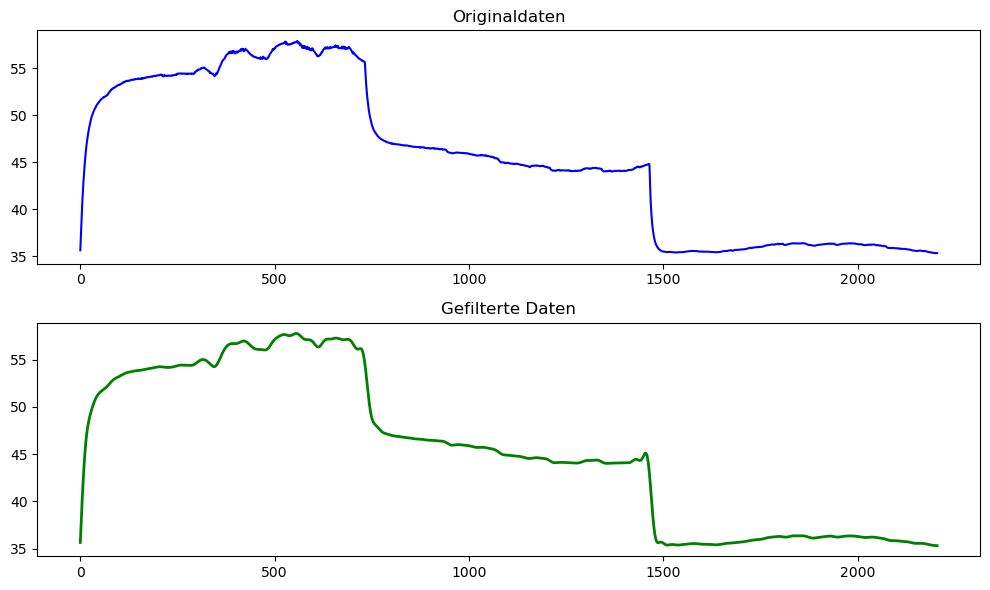

In [68]:
from scipy import signal

def butter_lowpass(cutoff, fs, order = 5):
    return scipy.signal.butter(order, cutoff, fs = fs, btype = 'low', analog = False)

def butter_lowpass_filter(data, cutoff, fs, order = 5):
    b, a = butter_lowpass(cutoff, fs, order = order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

order = 6
fs = 100.0
cutoff = 3.667

y = butter_lowpass_filter(data_means['ts1'], cutoff, fs, order)

print(y)
# Plots erzeugen
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Rohdaten plotten
ax[0].plot(data_means['ts1'], 'b-', label='Originaldaten')
ax[0].set_title('Originaldaten')

# Gefilterte Daten plotten
ax[1].plot(y, 'g-', linewidth=2, label='Gefilterte Daten')
ax[1].set_title('Gefilterte Daten')

plt.tight_layout()
plt.show()

In [69]:
def butter_lowpass(cutoff, fs, order = 5):
    return scipy.signal.butter(order, cutoff, fs = fs, btype = 'low', analog = False)

def butter_lowpass_filter(data, cutoff, fs, order = 5):
    b, a = butter_lowpass(cutoff, fs, order = order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

order = 6
fs = 100.0
cutoff = 3.667

for key in data_means:
    data_means[key] = butter_lowpass_filter(data_means[key], cutoff, fs, order)

In [ ]:
class ManualFeatureExtractor:
    def __init__(self, dataset):
        self.dataset = dataset
        
    def extract_features(self):
        features = {}
        for i, key in enumerate(self.dataset, start=1):
            #features[f"{key}_{i}_mean"] = self.dataset[key].mean(axis=1)
            #features[f"{key}_{i}_median"] = np.median(self.dataset[key], axis=1)
            features[f"{key}_{i}_std"] = self.dataset[key].std(axis=1)
            #features[f"{key}_{i}_min"] = self.dataset[key].min(axis=1)
            #features[f"{key}_{i}_max"] = self.dataset[key].max(axis=1)
            #features[f"{key}_{i}_range"] = self.dataset[key].max(axis=1) - self.dataset[key].min(axis=1)
        self.df_features = pd.DataFrame(features)
        return self.df_features

extractor = ManualFeatureExtractor(data_means)
df_features = extractor.extract_features()
print(df_features.shape, df_target.shape)

ValueError: If using all scalar values, you must pass an index

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

  
states = [27, 6728, 49122]
accs = []
features = df_features
target = df_target

for RANDOM_STATE in states:
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size = 0.2, random_state = RANDOM_STATE, stratify = target
    )
    
    model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accs.append(accuracy_score(y_test, preds))
    print(f"Random State: {RANDOM_STATE}")
    print(classification_report(y_test, preds, zero_division=0.0))

accs_mean = round(np.mean(accs), 4)
accs_std = round(np.std(accs), 4)

print(f"Mean Accuracy: {accs_mean}")
print(f"Std Accuracy: {accs_std}")

c:\Users\Daniel\anaconda3\envs\py_adv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Daniel\anaconda3\envs\py_adv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Random State: 27
              precision    recall  f1-score   support

        73.0       0.20      0.15      0.17        72
        80.0       0.26      0.17      0.20        72
        90.0       0.33      0.19      0.25        72
       100.0       0.62      0.82      0.70       225

    accuracy                           0.50       441
   macro avg       0.35      0.33      0.33       441
weighted avg       0.44      0.50      0.46       441

Random State: 6728
              precision    recall  f1-score   support

        73.0       0.45      0.25      0.32        72
        80.0       0.28      0.21      0.24        72
        90.0       0.35      0.08      0.13        72
       100.0       0.61      0.89      0.72       225

    accuracy                           0.54       441
   macro avg       0.42      0.36      0.35       441
weighted avg       0.49      0.54      0.48       441

Random State: 49122
              precision    recall  f1-score   support

        73.0       

c:\Users\Daniel\anaconda3\envs\py_adv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
